# Baseline Model for Spam classification: Naives Bayes

In [1]:
# Let's first import the needed libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import pickle
import scipy.sparse
import seaborn as sns
sns.set()

# To handle email messages
import email
from email.policy import default
from bs4 import BeautifulSoup

# Progression bar
import tqdm

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.naive_bayes
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Text handling
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string


## Data Preprocessing

We are going to be using the TREC 2005 dataset.

In [2]:
# Importing data

data = pd.read_csv('TREC05/full/index', delim_whitespace=True, header=None, names=['spam', 'email_id'])
data.email_id = data.email_id.str.replace('../data/', '')
data.head()

,spam,email_id
0,ham,000/000
1,ham,000/001
2,ham,000/002
3,ham,000/003
4,ham,000/004


In [3]:
first_time = True

In [4]:
# Reading all the emails

if first_time:
    parser = email.parser.BytesParser(policy=default)
    messages = []
    for id in tqdm.tqdm(data['email_id']):
        with open('TREC05/data/' + id, 'rb') as file:
            message = parser.parse(file)
            messages.append(message)

100%|██████████| 92189/92189 [02:04<00:00, 738.97it/s] 


In [5]:
# Creating the interesting features: parts, attachments, html, subject, body, links

if first_time:
    parts = []
    attachments = []
    html = []
    subjects = []
    body_list = []
    links = []

    for message in tqdm.tqdm(messages):
        # parts
        if not message.is_multipart():
            parts.append(0)        
        else:
            parts.append(len(list(message.walk())))

        # Attachments
        attach = 0
        for part in message.walk():
            cdispo = str(part.get('Content-Disposition'))
            if 'attachment' in cdispo:
                attach += 1
        attachments.append(attach)

        # Html
        html.append(1*('text/html' in [part.get_content_type() for part in message.walk()]))

        # Subject
        subjects.append(message.get('subject'))

        # Body and links
        for part in message.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                if type(body) == bytes:
                    body = body.decode('latin-1')

                link = 0
                break

            elif ctype == 'text/html' and 'attachment' not in cdispo:
                soup = BeautifulSoup(part.get_payload(decode=True), 'lxml')
                body = soup.find(text=True, recursive=False)
                if body == '':
                    continue
                else:
                    link = len(soup.find_all('a'))
                    break

        body_list.append(body)
        links.append(link)
    

100%|██████████| 92189/92189 [02:52<00:00, 533.24it/s] 


In [6]:
# Wrapping everyting up into a Dataframe
if first_time:
    df = pd.DataFrame({'email_id': data.email_id,
                         'parts': parts, 
                         'attachments': attachments, 
                         'html': html, 
                         'subject': subjects, 
                         'body': body_list, 
                         'links': links,
                         'spam': data.spam})

    df.to_csv('data05/email_data.csv', index=False)


## Preparing the dataset

In [8]:
# Importing the clean dataset

Email = pd.read_csv('data05/email_data.csv')
Email.head()

,email_id,parts,attachments,html,subject,body,links,spam
0,000/000,0,0,0,"FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,ham
1,000/001,0,0,0,NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,ham
2,000/002,0,0,0,RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,ham
3,000/003,0,0,0,FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,ham
4,000/004,0,0,0,New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,ham


In [9]:
# Cleaning the nan data
print(Email.isna().sum())
print('\nOnly Subject and Body contain nan. We will replace with empty strings!')

email_id          0
parts             0
attachments       0
html              0
subject        2061
body           8952
links             0
spam              0
dtype: int64

Only Subject and Body contain nan. We will replace with empty strings!


In [10]:
Email.fillna('', inplace=True)

In [11]:
# Generating a training set and test set

Training, Test = train_test_split(Email, test_size=0.15, random_state=1)
Training.shape, Test.shape

((78360, 8), (13829, 8))

## I. Structural Information model

The simplest spam detection model we will build will use only structural information about email messages.
We will use the following variables:
- **multipart**: 1 if message is multi-part, 0 otherwise.
- **html**: 1 if message contains a text/html part, zero otherwise. 
- **links**: 1 if message body contains hyperlinks, zero otherwise. 
- **attachments**: 1 if message contains attachments, zero otherwise.

In [12]:
# Training features
sim_multipart = np.where(Training.parts > 0, 1, 0)
sim_html = Training.html.values
sim_links = np.where(Training.links > 0, 1, 0)
sim_attachments = np.where(Training.attachments > 0, 1, 0)
sim_X_train = np.column_stack((sim_multipart, sim_html, sim_links, sim_attachments))
Y_train = np.where(Training.spam == 'spam', 1, 0)


# Test features
sim_multipart_test = np.where(Test.parts > 0, 1, 0)
sim_html_test = Test.html.values
sim_links_test = np.where(Test.links > 0, 1, 0)
sim_attachments_test = np.where(Test.attachments > 0, 1, 0)
sim_X_test = np.column_stack((sim_multipart_test, sim_html_test, sim_links_test, sim_attachments_test))
Y_test = np.where(Test.spam == 'spam', 1, 0)

In [13]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.BernoulliNB()
sim_cross_score = cross_val_score(NB_classifier, sim_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)


In [14]:
# Results
print('For this Strucural information model, the 5 fold cross validated AUC is: ', sim_cross_score.mean())


For this Strucural information model, the 5 fold cross validated AUC is:  0.7545258211024378


## II. Subject Model

For this model, we will focus on the subject part of the email, which is often where there is the most information concerning whether or not it is a spam. 
We will use the bag-of-word representation of the message subject.

In [15]:
# Building the bag of words representation


def stem_tokenizer(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]

punctuation = list(string.punctuation)
stop0 = stopwords.words("english") + punctuation
stop_words = set(stem_tokenizer(" ".join(stop0)))

#### Set features

In [16]:
# Building the bag of words representation with set features

setVectorizer_subject = CountVectorizer(input = 'content', tokenizer=stem_tokenizer, stop_words=stop_words, binary=True)
sub_X_train = setVectorizer_subject.fit_transform(Training.subject.values)
sub_X_test = setVectorizer_subject.transform(Test.subject.values)
print("Total Words: ",sub_X_train.sum())
print(sub_X_train.shape)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Total Words:  312408
(78360, 35087)


In [17]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
sub_set_cross_score = cross_val_score(NB_classifier, sub_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [18]:
# Results
print('For this subject model, using the set features, the 5 fold cross validated AUC is: ', sub_set_cross_score.mean())


For this subject model, using the set features, the 5 fold cross validated AUC is:  0.9759888130923112


#### tfidf features

In [19]:
# Building the bag of words representation with tfidf features

tfidfVectorizer_subject = TfidfVectorizer(input = 'content', tokenizer=stem_tokenizer, stop_words=stop_words)
sub_tfidf_X_train = tfidfVectorizer_subject.fit_transform(Training.subject.values)
sub_tfidf_X_test = tfidfVectorizer_subject.transform(Test.subject.values)
print(sub_tfidf_X_train.shape)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(78360, 35087)


In [20]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
sub_tfidf_cross_score = cross_val_score(NB_classifier, sub_tfidf_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [21]:
# Results
print('For this subject model, using the tfidf features, the 5 fold cross validated AUC is: ', sub_tfidf_cross_score.mean())


For this subject model, using the tfidf features, the 5 fold cross validated AUC is:  0.9774401572687725


## III. Message Body Model

For this model, we will focus on the body part of the email. As the text features are pretty long to generate, I will save them.

#### Set features

In [22]:
if first_time:
    
    # Building the set features
    setVectorizer_body = CountVectorizer(input = 'content', tokenizer=stem_tokenizer, stop_words=stop_words, binary=True)
    body_X_train = setVectorizer_body.fit_transform(Training.body.values)
    body_X_test = setVectorizer_body.transform(Test.body.values)
    print("Total Words: ",body_X_train.sum())
    
    # Saving set features 
    with open('data05/body_set_features.p', 'wb') as file:
        pickle.dump(body_X_train, file)

    with open('data05/body_set_test_features.p', 'wb') as file:
        pickle.dump(body_X_test, file)
    
    with open('data05/setVectorizer_body.p', 'wb') as file:
        pickle.dump(setVectorizer_body, file)
        
        
    
else :

    # Loading the features
    with open('data05/body_set_features.p', 'rb') as file:
        body_X_train = pickle.load(file)
    
    with open('data05/body_set_test_features.p', 'rb') as file:
        body_X_test = pickle.load(file)

    with open('data05/setVectorizer_body.p', 'rb') as file:
        setVectorizer_body = pickle.load(file)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Total Words:  6154865


In [23]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
body_set_cross_score = cross_val_score(NB_classifier, body_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [24]:
# Results
print('For this body model, using the set features, the 5 fold cross validated AUC is: ', body_set_cross_score.mean())


For this body model, using the set features, the 5 fold cross validated AUC is:  0.9665326789614553


#### tfidf features

In [25]:
if first_time:
    
    # Building the tfidf features
    tfidfVectorizer_body = TfidfVectorizer(input = 'content', tokenizer=stem_tokenizer, stop_words=stop_words)
    body_tfidf_X_train = tfidfVectorizer_body.fit_transform(Training.body.values)
    body_tfidf_X_test = tfidfVectorizer_body.transform(Test.body.values)
    
    # Saving set features 
    with open('data05/body_tfidf_features.p', 'wb') as file:
        pickle.dump(body_tfidf_X_train, file)
    
    with open('data05/body_tfidf_test_features.p', 'wb') as file:
        pickle.dump(body_tfidf_X_test, file)
           
    with open('data05/tfidfVectorizer_body.p', 'wb') as file:
        pickle.dump(tfidfVectorizer_body, file)

else : 
    
    # Loading the features
    with open('data05/body_tfidf_features.p', 'rb') as file:
        body_tfidf_X_train = pickle.load(file)
    
    with open('data05/body_tfidf_test_features.p', 'rb') as file:
        body_tfidf_X_test = pickle.load(file)
        
    with open('data05/tfidfVectorizer_body.p', 'rb') as file:
        tfidfVectorizer_body = pickle.load(file)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [26]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
body_tfidf_cross_score = cross_val_score(NB_classifier, body_tfidf_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [27]:
# Results
print('For this body model, using the tfidf features, the 5 fold cross validated AUC is: ', body_tfidf_cross_score.mean())


For this body model, using the tfidf features, the 5 fold cross validated AUC is:  0.9708042181488054


## IV. Number of links / attachments

Many spam emails come with a huge number of hyperlinks. We will now use this feature to see if we can have a satisfying result for our Naive Bayes classifier.

In [28]:
# Training features
link_X_train = pd.get_dummies(Training['links'])

# Test features
link_X_test = pd.get_dummies(Test.links)

In [29]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
link_cross_score = cross_val_score(NB_classifier, link_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [30]:
# Results
print('For this Strucural information model, the 5 fold cross validated AUC is: ', link_cross_score.mean())


For this Strucural information model, the 5 fold cross validated AUC is:  0.6200757907414672


Let's add the number of attachments

In [31]:
# Training features
link_attach_X_train = pd.get_dummies(Training[['links','attachments']])

# Test features
link_attach_X_test = pd.get_dummies(Test[['links','attachments']])

In [32]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
link_attach_cross_score = cross_val_score(NB_classifier, link_attach_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [33]:
# Results
print('For this Strucural information model, the 5 fold cross validated AUC is: ', link_attach_cross_score.mean())


For this Strucural information model, the 5 fold cross validated AUC is:  0.6299195908734554


## V. Combined Model

According to our previous studies, the best classifiers are those using the structural information of the email, the subject and the body content. We will therefore combine these model to build a more robust model.

In [34]:
# Training features
combined_X_train = scipy.sparse.hstack((scipy.sparse.csr_matrix(sim_X_train), sub_X_train, body_X_train))

# Test features
combined_X_test = scipy.sparse.hstack((scipy.sparse.csr_matrix(sim_X_test), sub_X_test, body_X_test))




In [35]:
# Building a Naive Bayes model
NB_classifier = sklearn.naive_bayes.MultinomialNB()
combined_cross_score = cross_val_score(NB_classifier, combined_X_train, Y_train, scoring='roc_auc', n_jobs=-1, cv=5)

In [36]:
# Results
print('For this body model, using the tfidf features, the 5 fold cross validated AUC is: ', combined_cross_score.mean())


For this body model, using the tfidf features, the 5 fold cross validated AUC is:  0.9878674228486958


## VI. Analyzing the different models

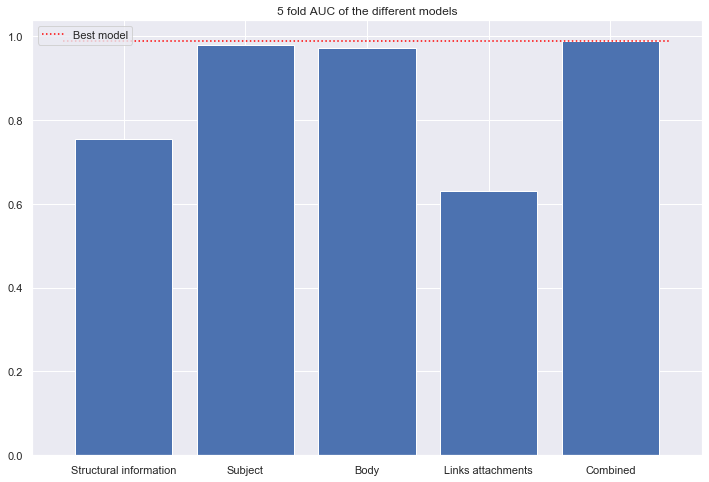

In [37]:
models = ['Structural information',
        'Subject',
        'Body',
        'Links attachments',
        'Combined']

aucs = [sim_cross_score.mean(),
        sub_tfidf_cross_score.mean(),
        body_tfidf_cross_score.mean(),
        link_attach_cross_score.mean(),
        combined_cross_score.mean()]
results = pd.DataFrame({'model':models, 'AUC':aucs})


plt.figure(figsize=(12, 8))
plt.bar(models, results.AUC)
plt.hlines(results.AUC.max(), -0.5, 4.5, 'red', linestyles='dotted', label='Best model')
plt.legend()
plt.title('5 fold AUC of the different models')
plt.show()

We see that our combined model is the one which has the highest AUC on the training set. We will train this model with the full training set and test its performance on the Test set.

### Best Model

In [38]:
# Training features
combined_X_train = scipy.sparse.hstack((scipy.sparse.csr_matrix(sim_X_train), sub_X_train, body_X_train))

# Test features
combined_X_test = scipy.sparse.hstack((scipy.sparse.csr_matrix(sim_X_test), sub_X_test, body_X_test))

In [39]:
# Building a Naive Bayes model
best_classifier = sklearn.naive_bayes.MultinomialNB()
best_classifier.fit(combined_X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [41]:
# Results on test set
y_pred = best_classifier.predict(combined_X_test)
print('Accuracy on the test set: \t', np.mean(y_pred == Y_test))
print('AUC on the test set:\t \t', roc_auc_score(Y_test, y_pred))

Accuracy on the test set: 	 0.9683997396774894
AUC on the test set:	 	 0.9689758257859419


### Analyzing ROC curve for all models

In [42]:
# Computing the ROC curves

# Structural information model

sim_classifier = sklearn.naive_bayes.BernoulliNB()
sim_classifier.fit(sim_X_train, Y_train)
sim_fpr, sim_tpr, sim_threshold = roc_curve(Y_test, sim_classifier.predict_proba(sim_X_test)[:,1])

# Subject based model

sub_classifier = sklearn.naive_bayes.MultinomialNB()
sub_classifier.fit(sub_tfidf_X_train, Y_train)
sub_fpr, sub_tpr, sub_threshold = roc_curve(Y_test, sub_classifier.predict_proba(sub_tfidf_X_test)[:,1])

# Body based model

body_classifier = sklearn.naive_bayes.MultinomialNB()
body_classifier.fit(body_X_train, Y_train)
body_fpr, body_tpr, body_threshold = roc_curve(Y_test, body_classifier.predict_proba(body_X_test)[:,1])

# Links and attachments model

links_classifier = sklearn.naive_bayes.MultinomialNB()
links_classifier.fit(link_attach_X_train, Y_train)
links_fpr, links_tpr, links_threshold = roc_curve(Y_test, links_classifier.predict_proba(link_attach_X_test)[:,1])


# Combined model
combined_classifier = sklearn.naive_bayes.MultinomialNB()
combined_classifier.fit(combined_X_train, Y_train)
combined_fpr, combined_tpr, combined_threshold = roc_curve(Y_test, combined_classifier.predict_proba(combined_X_test)[:,1])

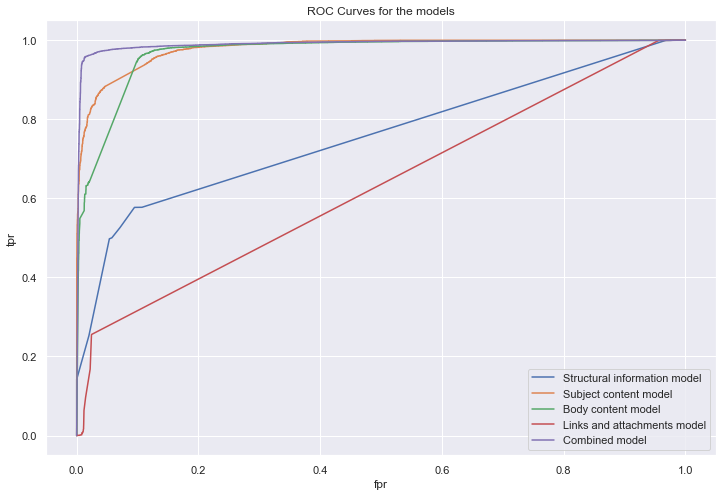

In [43]:
# Plotting the ROC curves

plt.figure(figsize=(12,8))

plt.plot(sim_fpr, sim_tpr, label='Structural information model')
plt.plot(sub_fpr, sub_tpr, label='Subject content model')
plt.plot(body_fpr, body_tpr, label='Body content model')
plt.plot(links_fpr, links_tpr, label='Links and attachments model')
plt.plot(combined_fpr, combined_tpr, label='Combined model')

plt.title('ROC Curves for the models')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(loc='lower right')

plt.show()

Some interesting questions may be to set up a threshold in order not to block too many good (ham) emails. As a matter of facts, for any mailboxes, it is obviously a better choice to misclassified a spam and let it go to the inbox rather than misclassify an important email and put it in the junk box.

In [46]:
# parts of good emails classified as spams, ie false positive
total_ham = (Y_test == 0).sum()
total_spam = (Y_test == 1).sum()
print('With the current optimal threshold (0.5):\npercentage of good emails blocked by our best classifier: ', 
      confusion_matrix(Y_test, combined_classifier.predict(combined_X_test))[0, 1] / total_ham)
print('percentage of spam emails blocked by our best classifier: ', 
      confusion_matrix(Y_test, combined_classifier.predict(combined_X_test))[1, 1] / total_spam)

With the current optimal threshold (0.5):
percentage of good emails blocked by our best classifier:  0.026644462947543714
percentage of spam emails blocked by our best classifier:  0.9645961145194274


If we want to reduce the number of ham emails being blocked, that is to say preventing too many good emails from being misclassified, we can increase the threshold:

In [48]:
# block no more than 1%
idx = (combined_fpr < 0.01).argmin() - 1
print(f'If we want to block no more than 1% of good emails, we must set the threshold to {combined_threshold[idx]}.')
print(f'In that case, the classifier will only be able to block  {combined_tpr[idx]} of spam emails.')

If we want to block no more than 1% of good emails, we must set the threshold to 0.9504676520888694.
In that case, the classifier will only be able to block  0.946319018404908 of spam emails.


In [50]:
# block no more than 0.2%
idx2 = (combined_fpr < 0.002).argmin() - 1
print('The index is', idx2)
print('therefore, we cannot block less than 0.2% of all good emails. \n\
If we want to achieve that, we must let all emails be classified negative (conservative classifier) \n\
and thus all spams emails would be missed.')

The index is 0
therefore, we cannot block less than 0.2% of all good emails. 
If we want to achieve that, we must let all emails be classified negative (conservative classifier) 
and thus all spams emails would be missed.


## VI. Running Models on TREC 2006

Let's try our models on the 2006 TREC dataset

## Data Preprocessing

In [51]:
# Importing data

data = pd.read_csv('TREC06/full/index', delim_whitespace=True, header=None, names=['spam', 'email_id'])
data.email_id = data.email_id.str.replace('../data/', '')
data.head()

,spam,email_id
0,ham,000/000
1,spam,000/001
2,spam,000/002
3,ham,000/003
4,spam,000/004


In [52]:
first_time = False

In [53]:
# Reading all the emails

if first_time:
    parser = email.parser.BytesParser(policy=default)
    messages = []
    for id in tqdm.tqdm(data['email_id']):
        with open('TREC06/data/' + id, 'rb') as file:
            message = parser.parse(file)
            messages.append(message)

In [54]:
# Creating the interesting features: parts, attachments, html, subject, body, links

if first_time:
    parts = []
    attachments = []
    html = []
    subjects = []
    body_list = []
    links = []

    for message in tqdm.tqdm(messages):
        # parts
        if not message.is_multipart():
            parts.append(0)        
        else:
            parts.append(len(list(message.walk())))

        # Attachments
        attach = 0
        for part in message.walk():
            cdispo = str(part.get('Content-Disposition'))
            if 'attachment' in cdispo:
                attach += 1
        attachments.append(attach)

        # Html
        html.append(1*('text/html' in [part.get_content_type() for part in message.walk()]))

        # Subject
        subjects.append(message.get('subject'))

        # Body and links
        for part in message.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                if type(body) == bytes:
                    body = body.decode('latin-1')

                link = 0
                break

            elif ctype == 'text/html' and 'attachment' not in cdispo:
                soup = BeautifulSoup(part.get_payload(decode=True), 'lxml')
                body = soup.find(text=True, recursive=False)
                if body == '':
                    continue
                else:
                    link = len(soup.find_all('a'))
                    break

        body_list.append(body)
        links.append(link)
    

In [55]:
# Wrapping everyting up into a Dataframe
if first_time:
    df = pd.DataFrame({'email_id': data.email_id,
                             'parts': parts, 
                             'attachments': attachments, 
                             'html': html, 
                             'subject': subjects, 
                             'body': body_list, 
                             'links': links,
                             'spam': data.spam})

    df.to_csv('data06/email_data_trec06.csv', index=False)
    df.head()

## Preparing the dataset

In [56]:
# Importing the clean dataset

Email_06 = pd.read_csv('data06/email_data_trec06.csv')
Email_06.head()

,email_id,parts,attachments,html,subject,body,links,spam
0,000/000,0,0,0,new Catholic mailing list now up and running,The mailing list I queried about a few weeks a...,0,ham
1,000/001,2,0,0,re[12]:,\n ...,0,spam
2,000/002,0,0,0,Take a moment to explore this.,Academic Qualifications available from prestig...,0,spam
3,000/003,0,0,0,Greetings,Greetings all. This is to verify your subscri...,0,ham
4,000/004,3,0,1,LOANS @ 3.17% (27 term),try chauncey may conferred the luscious not co...,0,spam


In [57]:
# Cleaning the nan data
print(Email_06.isna().sum())
print('\nOnly Subject and Body contain nan. We will replace with empty strings!')

email_id          0
parts             0
attachments       0
html              0
subject         387
body           1564
links             0
spam              0
dtype: int64

Only Subject and Body contain nan. We will replace with empty strings!


In [58]:
Email_06.fillna('', inplace=True)

We will try our models on the whole 2006 dataset.

### Preparing the features

In [59]:
# Structural information features
sim_multipart_06 = np.where(Email_06.parts > 0, 1, 0)
sim_html_06 = Email_06.html.values
sim_links_06 = np.where(Email_06.links > 0, 1, 0)
sim_attachments_06 = np.where(Email_06.attachments > 0, 1, 0)
sim_06 = np.column_stack((sim_multipart_06, sim_html_06, sim_links_06, sim_attachments_06))
Y_06 = np.where(Email_06.spam == 'spam', 1, 0)

In [62]:
# Subject content set features
sub_set_X_06 = setVectorizer_subject.transform(Email_06.subject.values)

In [69]:
# Body content set features
if first_time:
    body_set_X_06 = setVectorizer_body.transform(Email_06.body.values)
    with open('data06/body_set_X_06.p', 'wb') as file:
        pickle.dump(body_set_X_06, file)
        

else:
    with open('data06/body_set_X_06.p', 'rb') as file:
        body_set_X_06 = pickle.load(file)

In [70]:
# Links/attachments features
link_attach_X_06 = pd.get_dummies(Email_06[['links','attachments']])

In [71]:
# Combined features
combined_X_06 = scipy.sparse.hstack((scipy.sparse.csr_matrix(sim_06), sub_set_X_06, body_set_X_06))

## Predicting the outcome with our trained models

In [78]:
# Using our models

Classifiers = [sim_classifier, sub_classifier, body_classifier, links_classifier, combined_classifier]
Features_list = [sim_06, sub_set_X_06, body_set_X_06, link_attach_X_06, combined_X_06]
Results = pd.DataFrame(columns=['Structural information model', 'Subject content', 'Body content', 'Links and attachments', 'Combined model'],
                      index=['Accuracy', 'AUC'])

for idx, classifier in enumerate(Classifiers):
    Results.iloc[0, idx] = np.mean(classifier.predict(Features_list[idx]) == Y_06)
    Results.iloc[1, idx] = roc_auc_score(Y_06, classifier.predict(Features_list[idx]))
    
Results

,Structural information model,Subject content,Body content,Links and attachments,Combined model
Accuracy,0.657316,0.739279,0.905769,0.663688,0.928877
AUC,0.718127,0.696417,0.914642,0.507844,0.93293


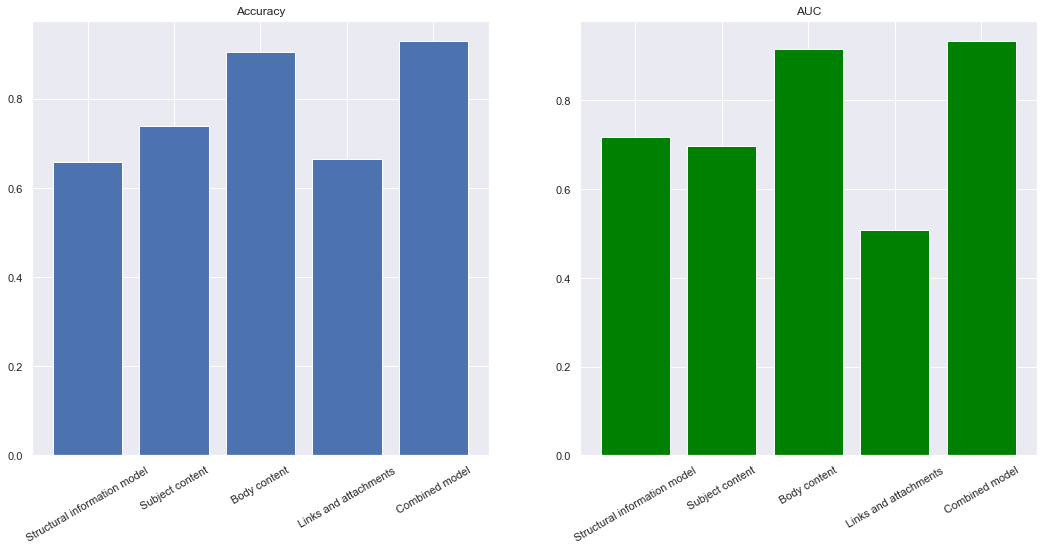

In [118]:
fig, ax = plt.subplots(1,2 , figsize=(18, 8))
ax[0].set_xticklabels(Results.columns, rotation=30)
ax[0].set_title('Accuracy')
ax[0].bar(Results.columns, Results.loc['Accuracy'])
ax[1].set_xticklabels(Results.columns, rotation=30)
ax[1].bar(Results.columns, Results.loc['AUC'], color='green')
ax[1].set_title('AUC')
plt.show()

In [116]:
# Computing the ROC curves

# Structural information model
sim_fpr, sim_tpr, sim_threshold = roc_curve(Y_06, sim_classifier.predict_proba(sim_06)[:,1])
print()

# Subject based model
sub_fpr, sub_tpr, sub_threshold = roc_curve(Y_06, sub_classifier.predict_proba(sub_set_X_06)[:,1])

# Body based model
body_fpr, body_tpr, body_threshold = roc_curve(Y_06, body_classifier.predict_proba(body_set_X_06)[:,1])

# Links and attachments model
links_fpr, links_tpr, links_threshold = roc_curve(Y_06, links_classifier.predict_proba(link_attach_X_06)[:,1])


# Combined model
combined_fpr, combined_tpr, combined_threshold = roc_curve(Y_06, combined_classifier.predict_proba(combined_X_06)[:,1])




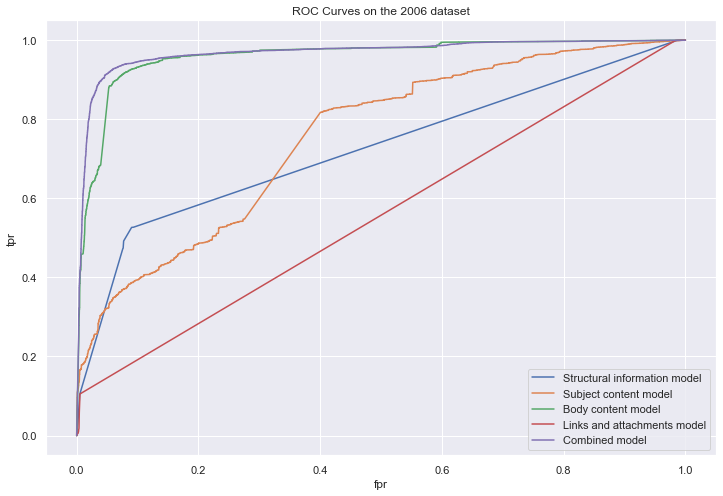

In [117]:
# Plotting the ROC curves

plt.figure(figsize=(12,8))

plt.plot(sim_fpr, sim_tpr, label='Structural information model')
plt.plot(sub_fpr, sub_tpr, label='Subject content model')
plt.plot(body_fpr, body_tpr, label='Body content model')
plt.plot(links_fpr, links_tpr, label='Links and attachments model')
plt.plot(combined_fpr, combined_tpr, label='Combined model')

plt.title('ROC Curves on the 2006 dataset')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(loc='lower right')

plt.show()

We can see that our best model still is the combined model. This is the one that generalizes the best and it has a pretty good accuracy on new data (92%) for the whole 2006 dataset.

# Conclusion

We have built and trained several NaiveBayes models on different types of features. This study has allowed us to better understand the structure of an email and which elements of that structure may have a great impact on wether or not an email should be thrust. In the end, it turned out that the bag of words models were the best ones but this is obviously not always the case.
Indeed, it is interesting to notice that the simple Structural information model has a slightly higher AUC than the Subject bag of words model when classifying the new data of the 2006 dataset. 

It is also interesting to see that the models performed differently between the original test set and the 2006 dataset. The overall performances are actually better for the original test set, which may be an indicator that the global structure of emails has a bit changed between 2005 and 2006, and that the emails of 2005 are somehow more correlated.

From the scope of that study, the best choice would now be to use the combined model which performs relatively well on new data and could be useful for this type of classification. Nevertheless, it is a model which has an important running time (mainly due to the Body bag of words representation part) which makes it difficult to deploy in a real life situation.




This study also allowed to give an explanation to a common method used by email services. Most of them provide methods for the user to notify the spam software that some messages have been miss-classified. As we have seen during the study, it is very complicated to reduce the number of good emails which are classified as spam without strongly deteriorating the sensitivity of the spam engine.
The help of the user can be higly efficient to help the software to understand the tiny elements which can ensure the message is a good one for this specific user and learn from it.

This study was a baseline for the development of more robust models using more complicated and approriate methods such as Gradient Boosted Trees or Dense Neural Network. The accuracies of the models in this study foresees a promising performance for futher models.